# Plot initial salinity profile and consequent max u velocities for each experiment.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import netCDF4 as nc
import cmocean as cm

from xgcm import Grid

In [11]:
basee = '/Users/claireyung/mom6/MOM6-examples/ocean_only/ISOMIP/seamount-icemount-PGtest/'
def open_files(label):
    base = basee 
    prog = xr.open_dataset(base + label+'/prog.nc')
    return prog
def open_IC(label):
    base = basee 
    IC = xr.open_dataset(base + label+'/MOM_IC.nc')
    return IC
def plot(ax,yy0,tt,variable,varname,vmin1,vmax1,cmap,ymax):
    prog = open_files(label)
    ocean_static = xr.open_dataset(label +'/ocean_geometry.nc')
    grid = Grid(prog,coords={"x":{"center":"xh","outer":"xq"},
                             "y":{"center":"yh","outer":"yq"},
                             "z":{"center":"zl","outer":"zi"}},periodic=False)
    file_name = label
    #IC = open_IC(label)
    depth = grid.interp(prog.e,"x")
    lon = ocean_static.geolonb
    dataplot = variable

    xx = lon
    if (varname == "uo") or (varname == "PFu") or (varname == "visc_rem_u"): 
        dataplot = grid.interp(dataplot,"x")
    levels = np.linspace(vmin1, vmax1, 51)
    yy = depth[:,:,yy0,:]
    z_levels = yy.shape[1]
    yi = np.linspace(0,5000,z_levels) 
    xi, yyi = np.meshgrid(xx[yy0,:], yi) 
    #print(xi.shape)
    #print(yy[tt,...].shape)
    #print(dataplot[tt,:,yy0,:].shape)
    cax = ax.pcolormesh(xi,yy[tt,...],dataplot[tt,:,yy0,:],vmin = vmin1, vmax = vmax1, cmap = cmap)
    
    #plt.colorbar(cax, ax = ax, label = varname)
    plt.colorbar(cax, ax = ax, label = 'u (m/s)')
    
    ## plot interface heights
    i_heights = prog.e # this is 'Interface Height Relative to Mean Sea Level'
    # do for one time
    i_heights = i_heights.isel(Time = tt)
    # take zonal mean
    i_heights = i_heights.isel(yh = yy0)#.mean('xh')

    # plot a line of layer depths, layer by layer
    nz = len(i_heights.zi)
    xh = prog.xh

    for i in range(nz):
        ax.plot(xh,i_heights[i], color = 'k', linewidth = 0.5)
    
    ax.set_ylim(ymin=-ymax,ymax=0)
    ax.set_ylabel('Depth (m)')
    ax.set_xlabel('x (km)')
    ax.set_title(varname+' , ' +label)
    


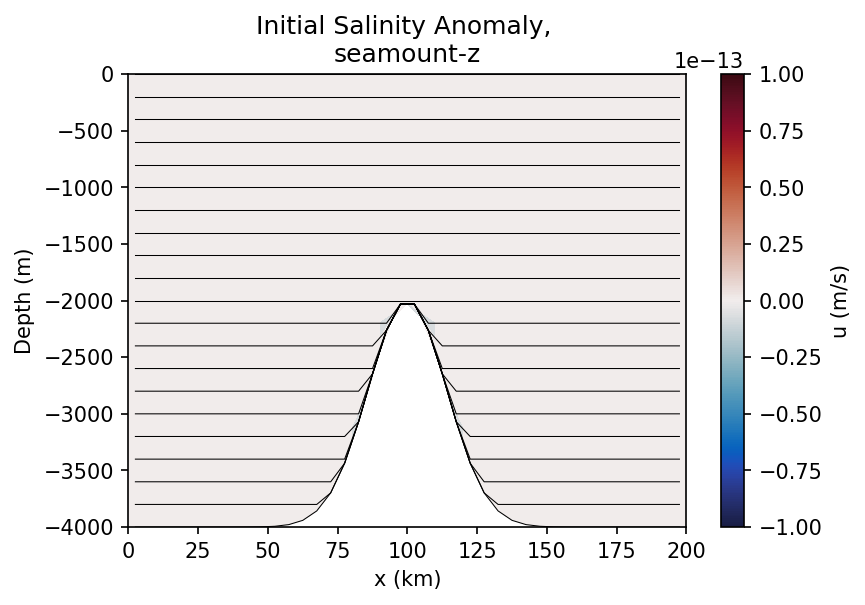

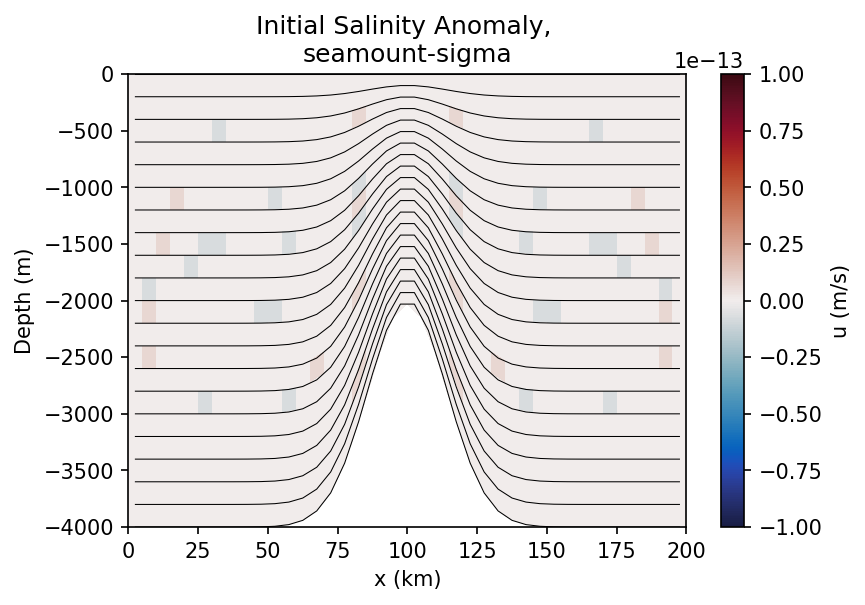

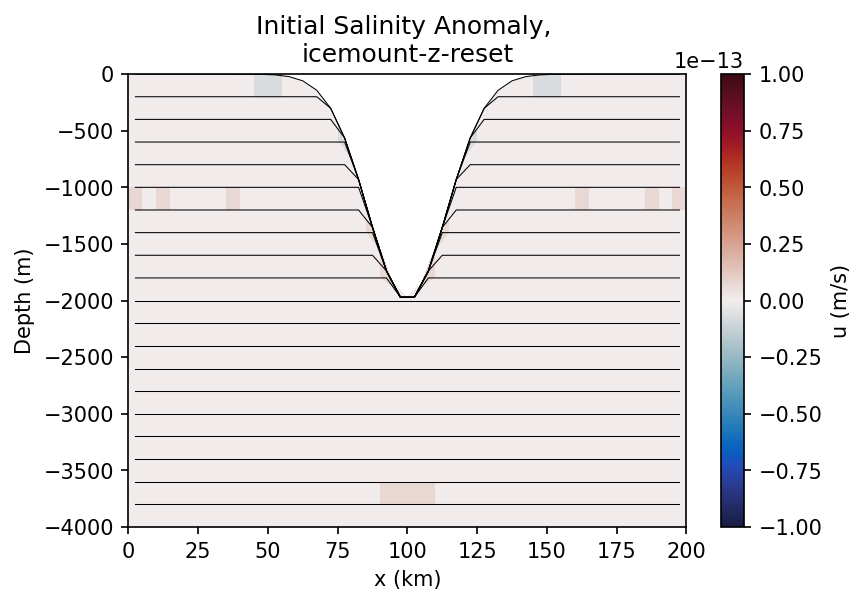

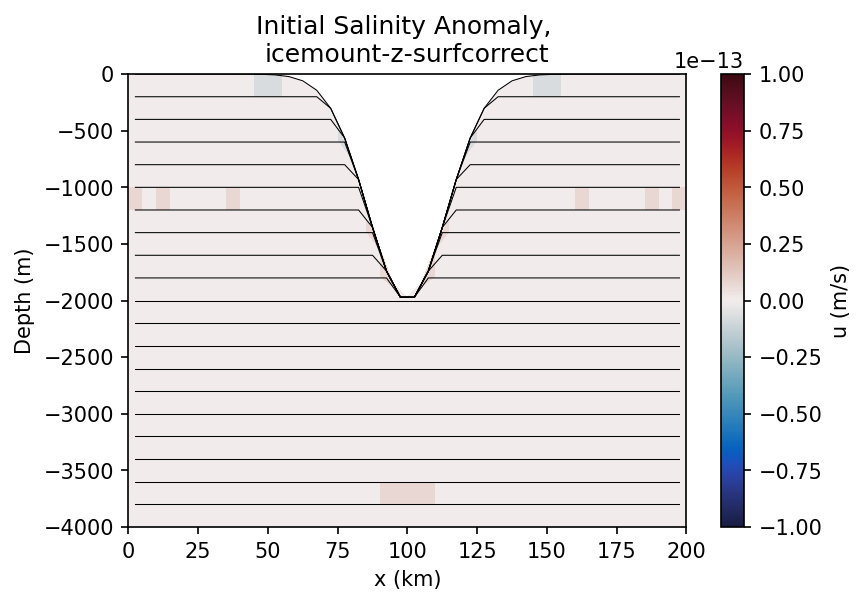

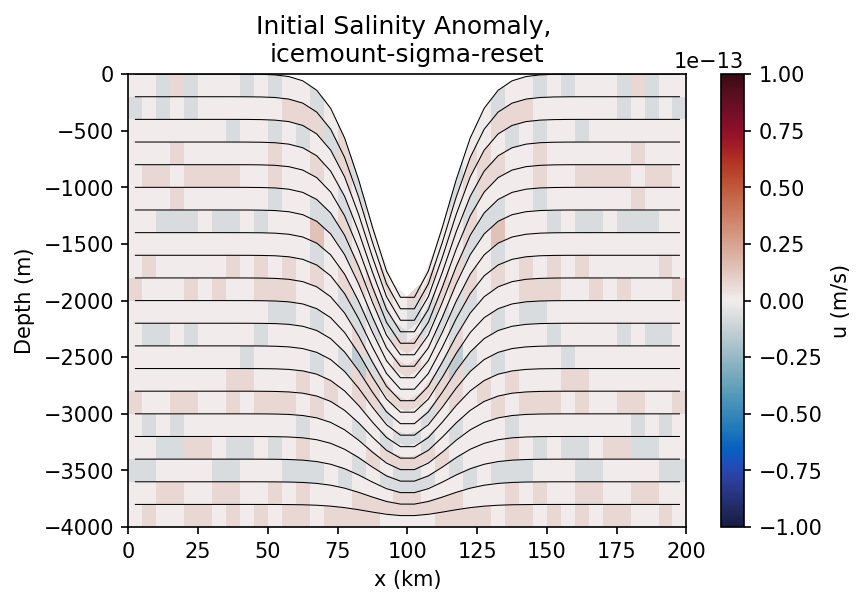

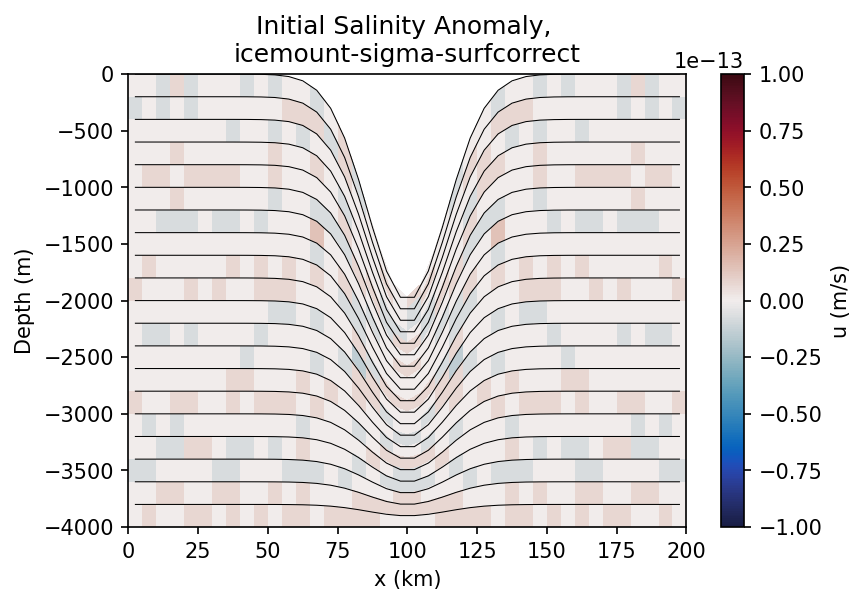

In [16]:
for label in ['seamount-z','seamount-sigma',
              'icemount-z-reset','icemount-z-surfcorrect',
              'icemount-sigma-reset','icemount-sigma-surfcorrect']:


    fig, axes = plt.subplots(dpi = 150)
    IC = open_IC(label)
    time = 0
    
    ideal_salt = xr.zeros_like(IC.Salt) + (IC.eta.isel(Interface = 0)-IC.h.cumsum('Layer')+IC.h/2)*(34.55-33.8)/(-4000) + 33.8
    plot(axes,x,time,IC.Salt-ideal_salt,"Salinity Anomaly from linear fit to centre of cell \n",-1e-13,1e-13,cm.cm.balance,ymax)
    axes.set_title('Initial Salinity Anomaly, \n'+label)
    plt.show()


Initialisation good.

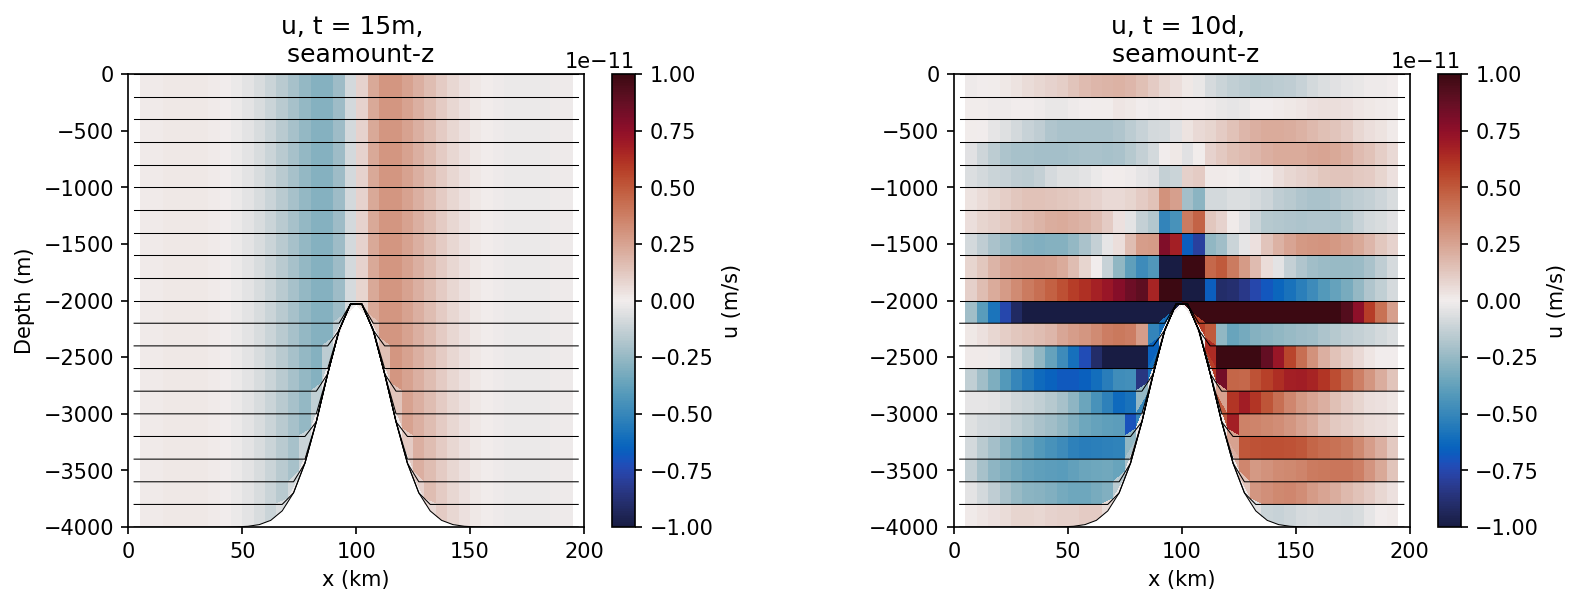

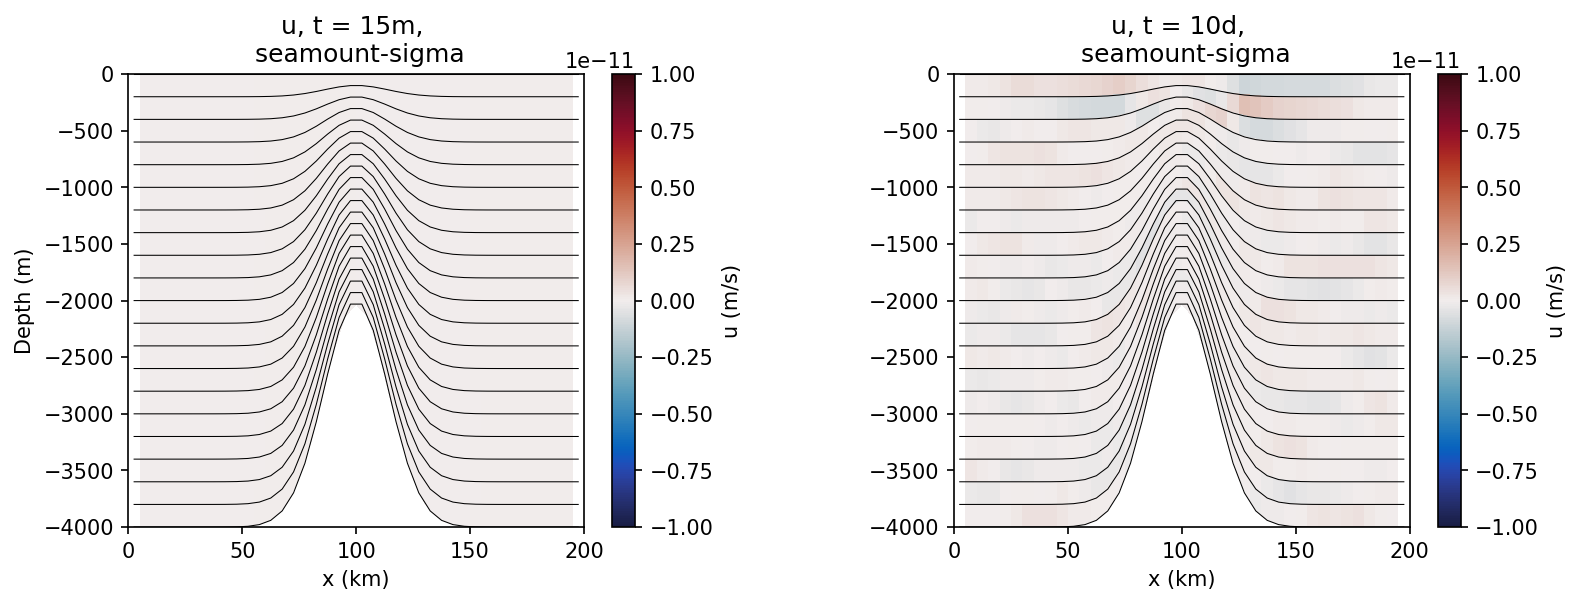

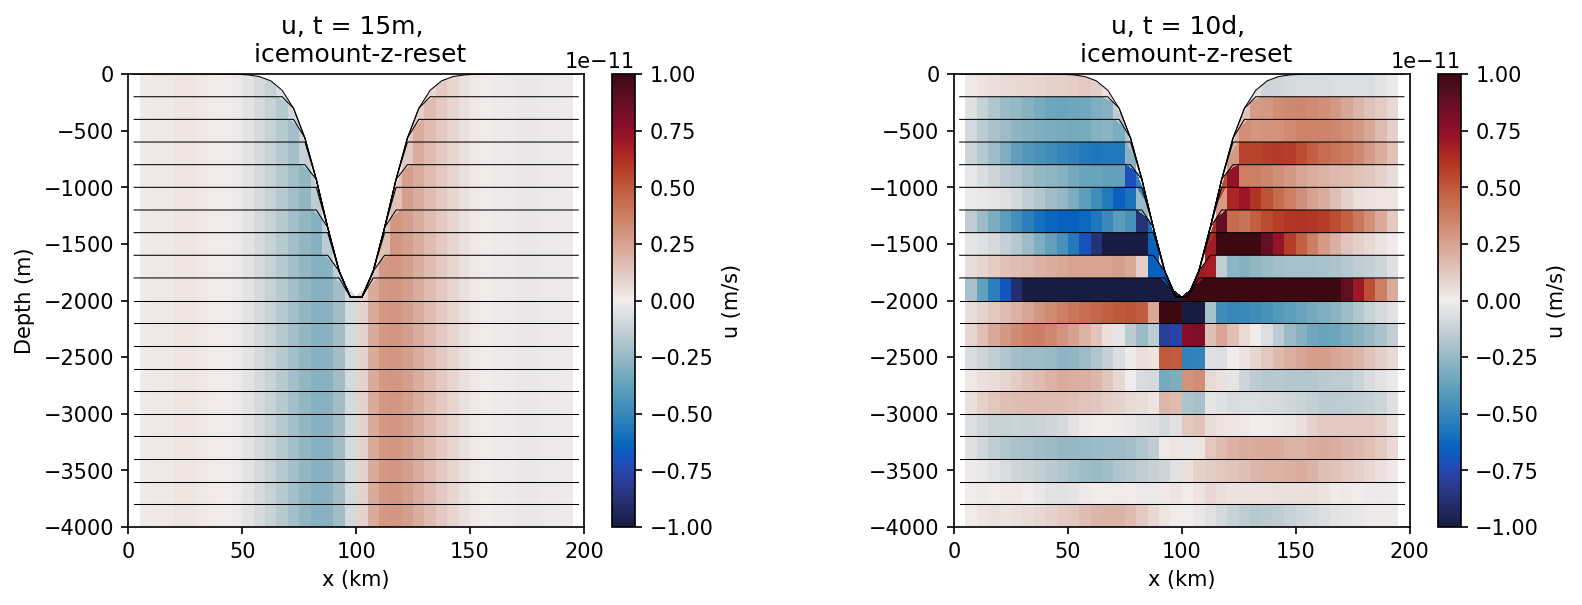

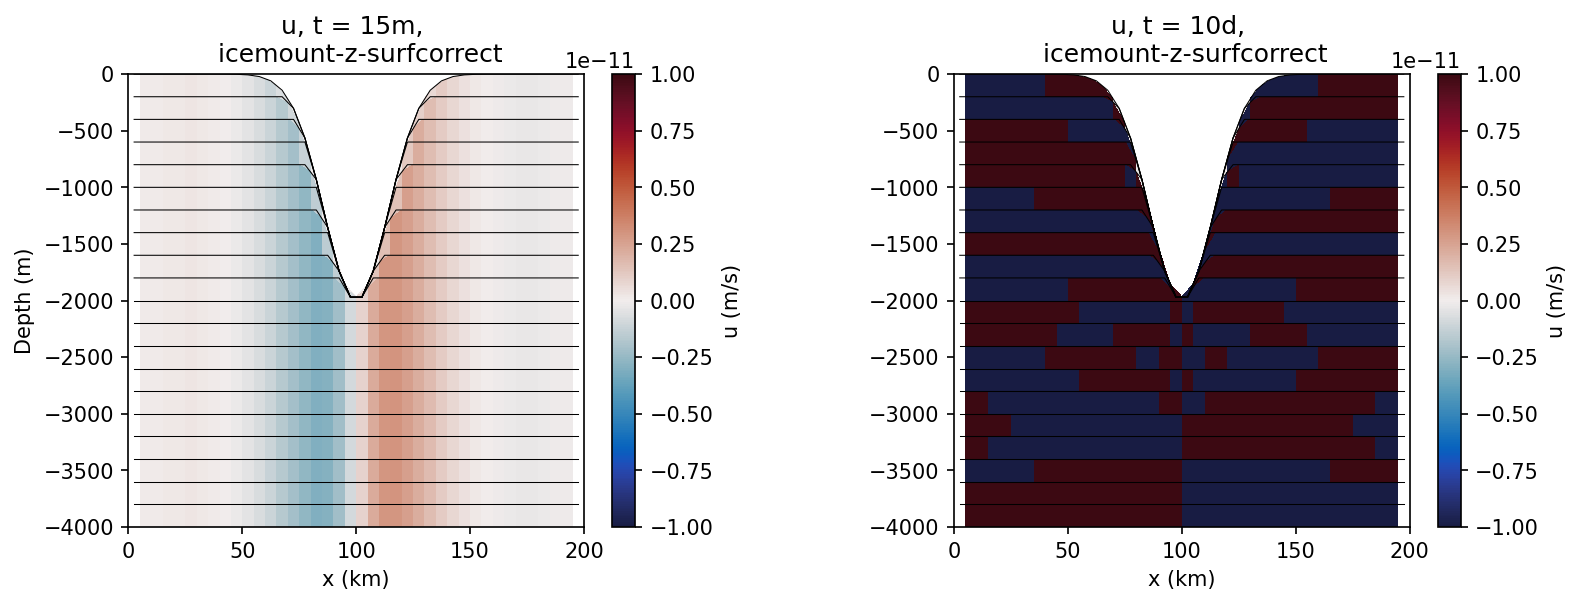

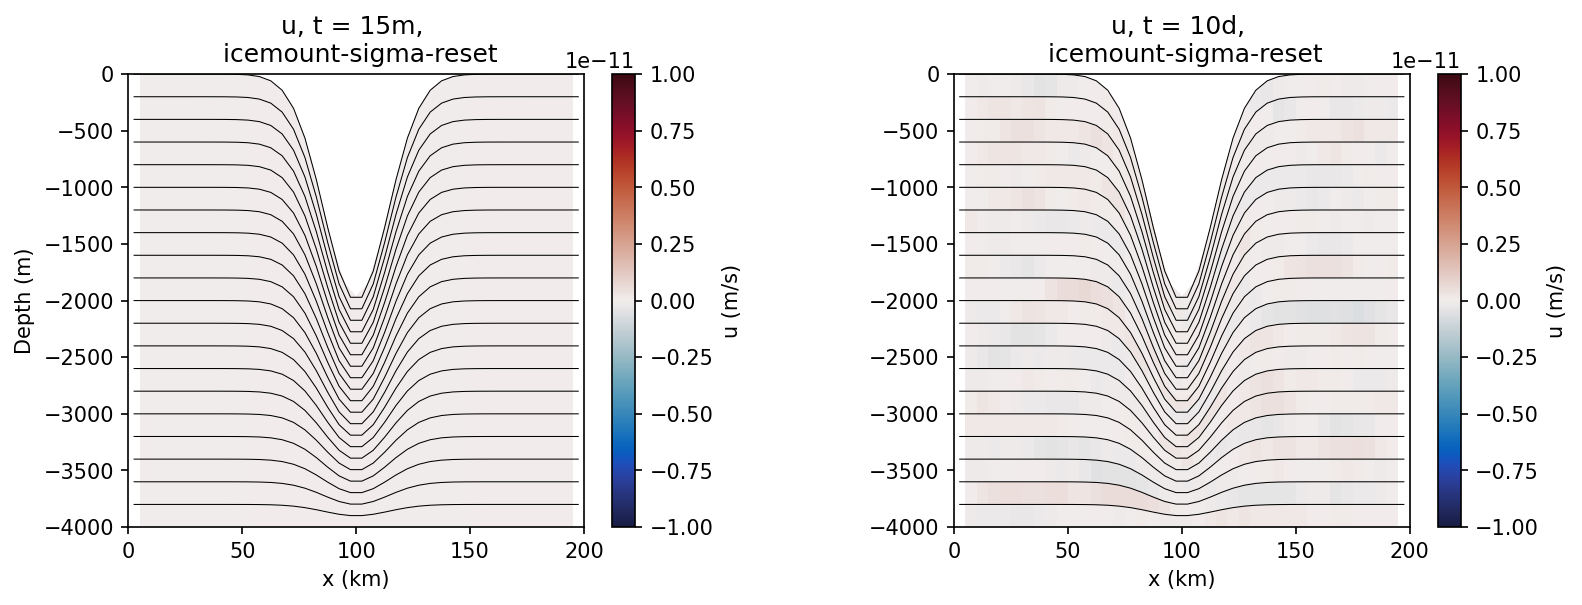

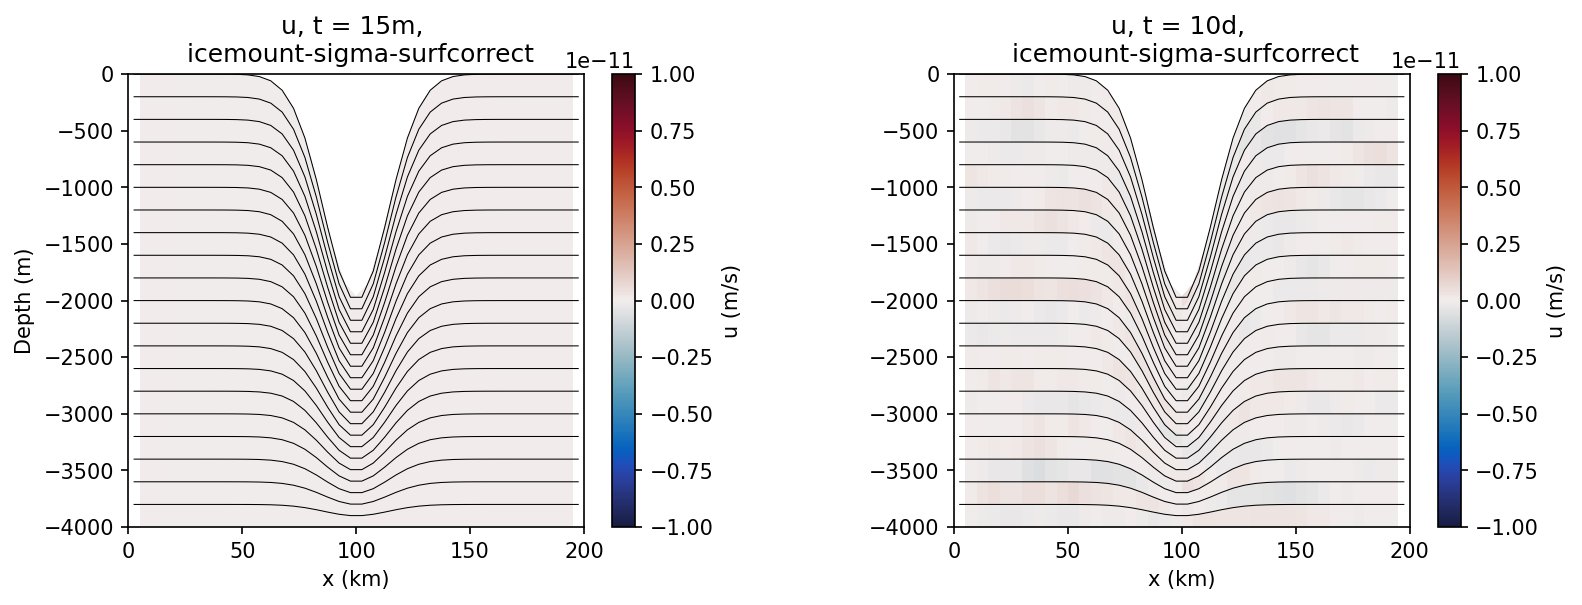

In [12]:
for label in ['seamount-z','seamount-sigma',
              'icemount-z-reset','icemount-z-surfcorrect',
              'icemount-sigma-reset','icemount-sigma-surfcorrect']:


    fig, axes = plt.subplots(ncols = 2, figsize = (12,4),dpi = 150)
    prog = open_files(label)
    x = 0
    ymax = 4000
    plot(axes[0],x,0,prog.u,"uo",-1e-11,1e-11,cm.cm.balance,ymax)

    plot(axes[1],x,-1,prog.u,"uo",-1e-11,1e-11,cm.cm.balance,ymax)

    axes[1].set_ylabel('')
    axes[0].set_title('u, t = 15m, \n '+label)
    axes[1].set_title('u, t = 10d, \n '+label)
    fig.subplots_adjust(wspace = 0.45)
    plt.show()


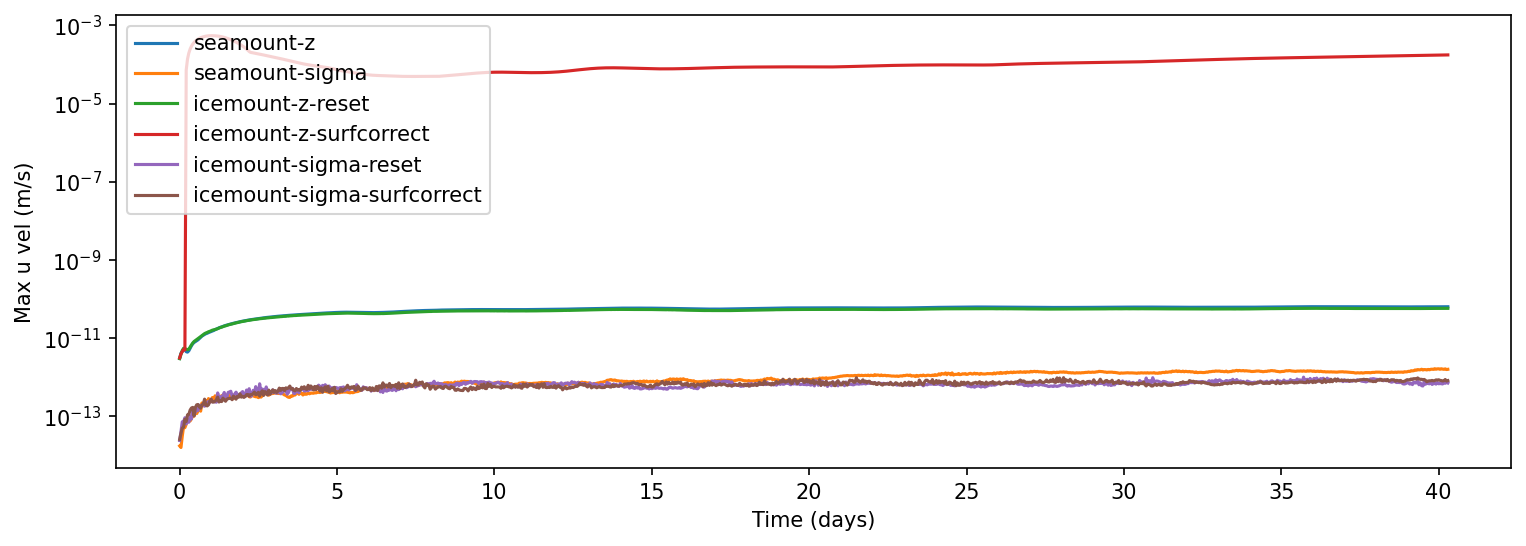

In [18]:
fig, axes = plt.subplots(figsize = (12,4),dpi = 150)

for label in ['seamount-z','seamount-sigma',
              'icemount-z-reset','icemount-z-surfcorrect',
              'icemount-sigma-reset','icemount-sigma-surfcorrect']:


    prog = open_files(label)
    axes.plot(np.arange(len(prog.Time))/24,np.abs(prog.u).max(['zl','yh','xq']), 
                 label = label) 
axes.set_ylabel('Max u vel (m/s)')
axes.set_xlabel('Time (days)')
axes.set_yscale('log')
plt.legend()

Low spurious currents for all except `icemount-z-surfcorrect` which has the problem that vanishing layers mess up the otherwise perfect surface pressure. This is fixed in `icemount-z-reset` with `MASS_WEIGHT_IN_PRESSURE_GRADIENT` implemented for ice shelves, and resetting the integral at a nonvanished and nonMWIPG affected layer.